In [1]:
from datetime import datetime
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib
from matplotlib import pyplot
import numpy as np
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print('env pass')

env pass


In [2]:
n_features = 1
n_steps = 30
df = read_csv('Linkou2.csv')
df_n = np.array([[i[1]] for i in df.values])
scaler = MinMaxScaler(feature_range=(0, 1))
df_n = scaler.fit_transform(df_n)

In [3]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [4]:
# data subgroup train = alldata - 365, test = 365
sub_g = len(df_n)-365
Train_sub = df_n[:sub_g]
Test_sub = df_n[sub_g:]
X_T, y_T = split_sequence(Train_sub, 30)
X_t, y_t = split_sequence(Test_sub, 30)

In [5]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import load_model, Model
from attention import Attention

In [6]:
def model_class(model_name, X_T, y_T, X_t, y_t,units):
    model = Sequential()
    if 'base' in model_name:
        model.add(LSTM(units, activation='relu', input_shape=(n_steps, n_features)))

    elif 'stack' in model_name:
        # model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(n_steps, n_features)))
        model.add(LSTM(units, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
        model.add(LSTM(units, activation='relu'))

    elif 'bidirect' in model_name:
        model.add(Bidirectional(LSTM(units, activation='relu'), input_shape=(n_steps, n_features)))
        
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    print(f'----------start train {model_name}----------')
    history = model.fit(X_T, y_T, epochs=50, validation_data=(X_t, y_t), verbose=0)
    print(f'----------start test {model_name}----------')
    trainPred = model.predict(X_T)
    testPred = model.predict(X_t)
    
    return history, trainPred, testPred



In [7]:
model_list = ['base lstm', 'stack lstm', 'bidirect lstm']
train_pred_list=[]
test_pred_list=[]
histroy_list=[]
for i in model_list:
    # model_class def function = (model name, train data, train label, test data, test label, units number)
    history, trainPred, testPred = model_class(i, X_T, y_T, X_t, y_t, 100)
    train_pred_list.append(trainPred)
    test_pred_list.append(testPred)
    histroy_list.append(history)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
----------start train base lstm----------
----------start test base lstm----------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dens

/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


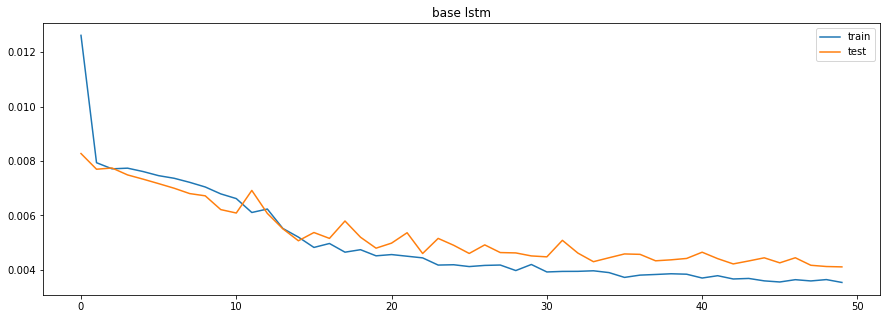

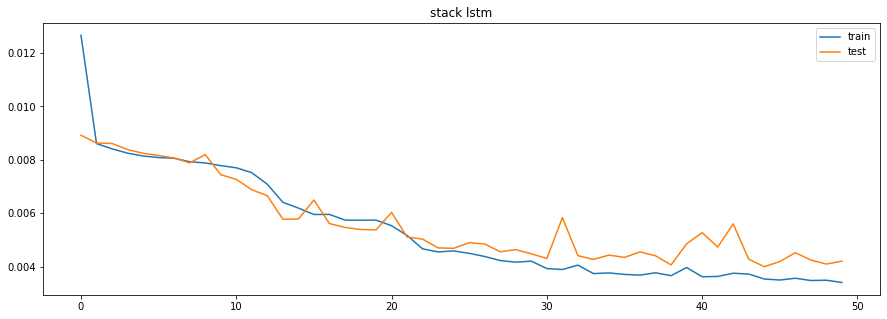

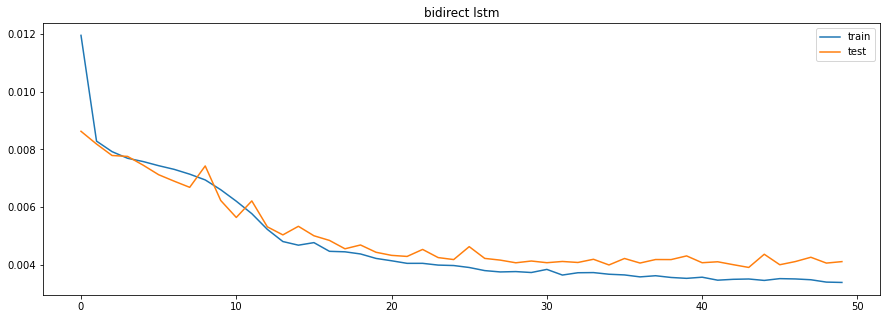

In [8]:
import matplotlib.pyplot as plt
for j in range (len(histroy_list)):
    plt.figure(figsize=(15,5))
    plt.plot(histroy_list[j].history['loss'], label='train')
    plt.plot(histroy_list[j].history['val_loss'], label='test')
    plt.title(f'{model_list[j]}')
    plt.legend()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    plt.savefig(f'Results/ Results Plot test - {model_list[j]} {current_time}.jpg')
    # plt.show()

In [9]:
# invert predictions
def data_rescaler(input_data):
    output_data = scaler.inverse_transform(input_data)
    return output_data


In [10]:
import math
from keras import backend as K
from keras.metrics import mean_absolute_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


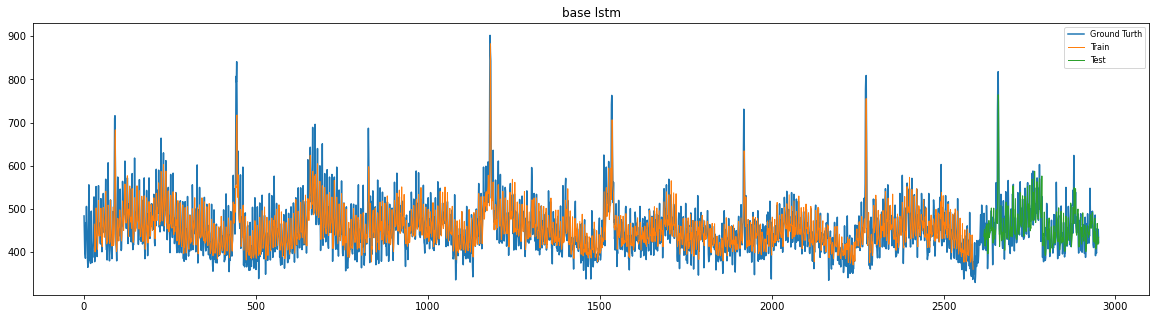

/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


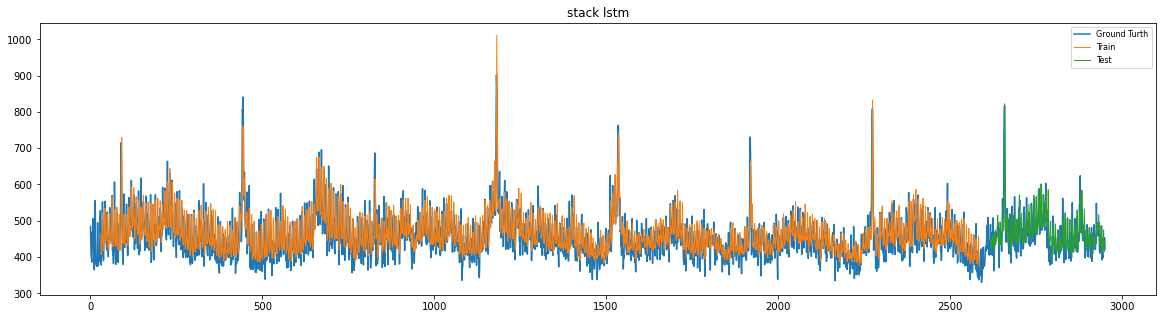

/home/john/anaconda3/envs/lstm_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


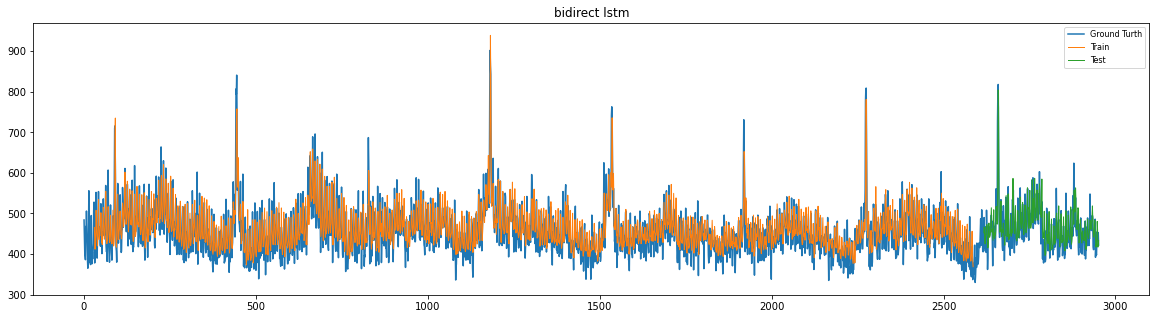

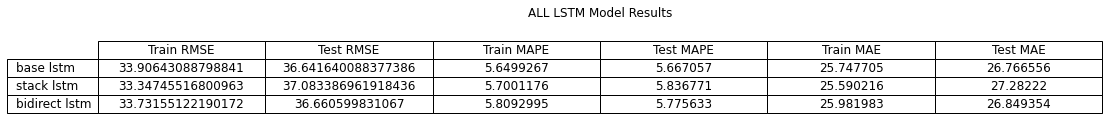

In [21]:
# metric code
model_metric_stack = []
metric_list = ['Train RMSE', 'Test RMSE', 'Train MAPE', 'Test MAPE', 'Train MAE', 'Test MAE']
for i in range(len(model_list)):
    all_metric_stack = []
    trainY = data_rescaler(y_T)
    testY = data_rescaler(y_t)
    trainPredict = data_rescaler(train_pred_list[i])
    testPredict = data_rescaler(test_pred_list[i])
    # RMSE
    all_metric_stack.append((root_mean_squared_error(trainY[:,0], trainPredict[:,0])).numpy())
    all_metric_stack.append((root_mean_squared_error(testY[:,0], testPredict[:,0])).numpy())
    # MAPE
    all_metric_stack.append((mean_absolute_percentage_error(trainY[:,0], trainPredict[:,0])).numpy())
    all_metric_stack.append((mean_absolute_percentage_error(testY[:,0], testPredict[:,0])).numpy())
    # MAE
    all_metric_stack.append((mean_absolute_error(trainY[:,0], trainPredict[:,0])).numpy())
    all_metric_stack.append((mean_absolute_error(testY[:,0], testPredict[:,0])).numpy())
    model_metric_stack.append(all_metric_stack)

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(df_n)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[30:len(trainPredict)+30, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df_n)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+60:, :] = testPredict
    # plot baseline and predictions
    plt.figure(figsize=(20,5))
    plt.title(f'{model_list[i]}')
    plt.plot(scaler.inverse_transform(df_n), linewidth=1.5, label = 'Ground Turth')
    plt.plot(trainPredictPlot, linewidth=1, label='Train')
    plt.plot(testPredictPlot, linewidth=1, Label='Test')
    plt.legend(fontsize=8)
    if not os.path.exists('Results'):
        os.makedirs('Results')
    plt.savefig(f'Results/plot baseline and predictions test - {current_time}.jpg')
    plt.show()





fig = plt.figure(figsize=(12, 2))
plt.axis('off')
plt.axis('tight')
plt.title('ALL LSTM Model Results')
tab1 = plt.table(cellText=model_metric_stack, rowLabels = model_list, colLabels=metric_list, cellLoc='center',loc='center')
tab1.scale(1.5,1.5)
tab1.set_fontsize(14)
